# Previsão de Qualidade do Vinho

Teste realizado para a *cognitivo.ai*, com o objetivo de criar um modelo para estimar a qualidade do vinho, com base em de vinhos portugueses "Vinho Verde", que possuem variantes de vinho branco e tinto. Devido a questões de privacidade, apenas variáveis físico-químicas (input) e sensoriais (output) estão disponíveis (por exemplo, não há dados sobre tipo de uva, marca do vinho, preço de venda, etc).

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import utils

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

## Leitura da base raw

In [2]:
wine_raw_df = pd.read_csv('data-raw/winequality.csv', sep=';')

## Análise dos dados

Vamos observar uma amostra dos dados e seus tipos: 

In [3]:
wine_raw_df.head(10)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
5,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
6,White,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6
7,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
8,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
9,White,8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11,6


In [50]:
wine_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
type                    6497 non-null object
fixed acidity           6497 non-null float64
volatile acidity        6497 non-null float64
citric acid             6497 non-null float64
residual sugar          6497 non-null float64
chlorides               6497 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null object
quality                 6497 non-null int64
dtypes: float64(10), int64(1), object(2)
memory usage: 659.9+ KB


Temos a variável **type** como categórica, e a **alcohol** que foi lida como categórica mas aparentemente é numérica. Provável problema na consistência dos dados. Podemos presumir que alguns dos valores inconsistentes aparecerão apenas uma vez.

In [52]:
alcohol_counts = wine_raw_df.alcohol.value_counts()
alcohol_counts[alcohol_counts == 1]

12.05                  1
112.666.666.666.667    1
114.666.666.666.667    1
9.95                   1
13.05                  1
105.333.333.333.333    1
131.333.333.333.333    1
12.25                  1
10.98                  1
10.65                  1
9.05                   1
963.333.333.333.333    1
113.666.666.666.667    1
8.0                    1
14.9                   1
11.35                  1
114.333.333.333.333    1
135.666.666.666.667    1
105.666.666.666.667    1
956.666.666.666.667    1
9.75                   1
923.333.333.333.333    1
117.333.333.333.333    1
11.85                  1
11.55                  1
9.25                   1
14.2                   1
13.55                  1
14.05                  1
10.75                  1
11.65                  1
123.333.333.333.333    1
8                      1
120.666.666.666.667    1
Name: alcohol, dtype: int64

Conforme esperado, uma inconsistência nos dados transformou valores numéricos em *string*. Podemos corrigir esse problema:

In [54]:
wine_raw_df['alcohol'] = wine_raw_df['alcohol'].apply(utils.convert_alcohol_str)

In [55]:
wine_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
type                    6497 non-null object
fixed acidity           6497 non-null float64
volatile acidity        6497 non-null float64
citric acid             6497 non-null float64
residual sugar          6497 non-null float64
chlorides               6497 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null float64
quality                 6497 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 659.9+ KB


Verificando o comportamento da resposta (**quality**):

In [53]:
wine_raw_df.quality.value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

Variável lida como numérica, porém seus valores são discretos compreendidos no conjunto {3, 4, 5, 6, 7, 8, 9}

Separando em treino/teste, respeitando a distribuição da resposta

In [6]:
X = wine_raw_df.drop(['quality'], axis=1)
y = wine_raw_df.quality

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, stratify=y)

In [7]:
y_train.value_counts()

6    2127
5    1603
7     809
4     162
8     145
3      22
9       4
Name: quality, dtype: int64

In [14]:
X_train.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
fixed acidity,1.000000,0.215594,0.327972,-0.115666,0.288835,-0.279962,-0.318709,0.133013,-0.245051,0.307797,-0.086591
volatile acidity,0.215594,1.000000,-0.378241,-0.203621,0.372003,-0.349646,-0.407339,0.019756,0.259187,0.229413,-0.044937
citric acid,0.327972,-0.378241,1.000000,0.137212,0.053280,0.128138,0.192787,0.045400,-0.332238,0.067929,-0.011559
residual sugar,-0.115666,-0.203621,0.137212,1.000000,-0.133040,0.416324,0.494536,0.172965,-0.275004,-0.190867,-0.360607
chlorides,0.288835,0.372003,0.053280,-0.133040,1.000000,-0.186286,-0.265075,0.063130,0.046401,0.411144,-0.254920
free sulfur dioxide,-0.279962,-0.349646,0.128138,0.416324,-0.186286,1.000000,0.722339,0.044074,-0.153160,-0.199671,-0.194670
total sulfur dioxide,-0.318709,-0.407339,0.192787,0.494536,-0.265075,0.722339,1.000000,0.044922,-0.238973,-0.275252,-0.273967
density,0.133013,0.019756,0.045400,0.172965,0.063130,0.044074,0.044922,1.000000,-0.050245,0.055758,-0.089930
pH,-0.245051,0.259187,-0.332238,-0.275004,0.046401,-0.153160,-0.238973,-0.050245,1.000000,0.204205,0.114722
sulphates,0.307797,0.229413,0.067929,-0.190867,0.411144,-0.199671,-0.275252,0.055758,0.204205,1.000000,-0.004947


In [11]:
abs(X_train.corr())[abs(X_train.corr()) > 0.5]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
fixed acidity,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
volatile acidity,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
citric acid,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
residual sugar,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chlorides,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
free sulfur dioxide,NaN,NaN,NaN,NaN,NaN,1.000000,0.722339,NaN,NaN,NaN,NaN
total sulfur dioxide,NaN,NaN,NaN,NaN,NaN,0.722339,1.000000,NaN,NaN,NaN,NaN
density,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
pH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
sulphates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [15]:
X_train.corrwith(y_train)

fixed acidity          -0.081198
volatile acidity       -0.272141
citric acid             0.084863
residual sugar         -0.025271
chlorides              -0.201089
free sulfur dioxide     0.067487
total sulfur dioxide   -0.034429
density                -0.035352
pH                      0.013683
sulphates               0.030382
alcohol                 0.443432
dtype: float64

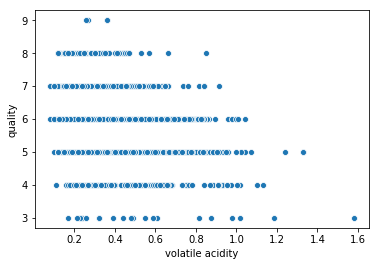

In [47]:
sns.scatterplot(x='volatile acidity', y='quality', data=pd.concat([X_train, y_train], axis=1))

In [41]:
pd.concat([X_train, y_train], axis=1)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
249,White,6.1,0.410,0.14,10.40,0.037,18.0,119.0,0.99600,3.38,0.45,10.00,5
4718,White,5.2,0.240,0.15,7.10,0.043,32.0,134.0,0.99378,3.24,0.48,9.90,6
3325,White,6.8,0.250,0.28,5.00,0.035,42.0,126.0,0.99048,3.12,0.38,12.60,7
1419,White,7.6,0.140,0.74,1.60,0.040,27.0,103.0,0.99160,3.07,0.40,10.80,7
6112,Red,10.2,0.330,0.46,1.90,0.081,6.0,9.0,0.99628,3.10,0.48,10.40,6
667,White,7.1,0.170,0.38,7.40,0.052,49.0,182.0,0.99580,3.35,0.52,9.60,6
5258,Red,8.2,0.700,0.23,2.00,0.099,14.0,81.0,0.99730,3.19,0.70,9.40,5
4668,White,6.0,0.170,0.33,6.00,0.036,30.0,111.0,0.99362,3.32,0.58,10.15,7
3904,White,5.0,0.455,0.18,1.90,0.036,33.0,106.0,0.98746,3.21,0.83,14.00,7
3129,White,6.1,0.210,0.38,1.50,0.039,37.0,122.0,0.98972,3.20,0.43,12.00,6


In [ ]:
a